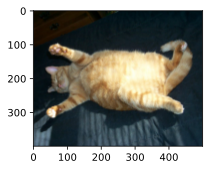

In [1]:
"""
    We mentioned that large datasets are a prerequisite for the success of deep neural networks in various applications.
mage augmentation generates similar but distinct training examples after a series of random changes to the training
mages, thereby expanding the size of the training set. Alternatively, image augmentation can be motivated by the fact
that random tweaks of training examples allow models to less rely on certain attributes, thereby improving their
generalization ability. For example, we can crop an image in different ways to make the object of interest appear
in different positions, thereby reducing the dependence of a model on the position of the object. We can also adjust
factors such as brightness and color to reduce a model’s sensitivity to color. It is probably true that image
augmentation was indispensable for the success of AlexNet at that time. In this section we will discuss this widely
used technique in computer vision.

**************** Common Image Augmentation Methods ******************

In our investigation of common image augmentation methods, we will use the following  image an 400 x 500 example.
Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of
image augmentation, next we define an auxiliary function apply. This function runs the image augmentation method aug
multiple times on the input image img and shows all the results.


"""

import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('cat1.jpg')
d2l.plt.imshow(img)

Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of image augmentation, next we define an auxiliary function apply. This function runs the image augmentation method aug multiple times on the input image img and shows all the results.

In [2]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

## Flipping and Cropping

Flipping the image left and right usually does not change the category of the object. This is one of the earliest and most widely used methods of image augmentation. Next, we use the transforms module to create the RandomHorizontalFlip instance, which flips an image left and right with a 50% chance.

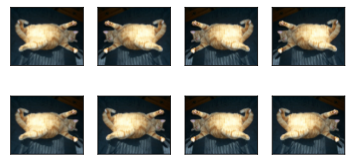

In [7]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

Flipping up and down is not as common as flipping left and right. But at least for this example image, flipping up and down does not hinder recognition.

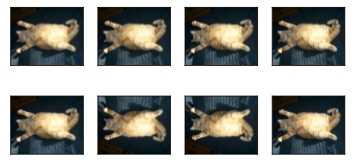

In [8]:
apply(img, torchvision.transforms.RandomVerticalFlip())

In the example image we used, the cat is in the middle of the image, but this may not be the case in general.In addition, we can also randomly crop the image to make objects appear in different positions in the image at different scales, which can also reduce the sensitivity of a model to the target position.

In the code below, we randomly crop an area with an area of 10% ~ 100% of the original area each time, and the ratio of width to height of this area is randomly selected from 0.5~2 Then, the width and height of the region are both scaled to 200 pixels. Unless otherwise specified, the random number between  a and b in this section refers to a continuous value obtained by random and uniform sampling from the interval [a, b].

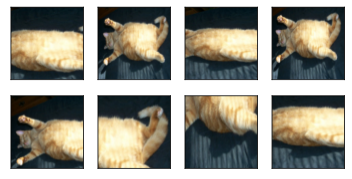

In [9]:
shape_au = torchvision.transforms.RandomResizedCrop((200,200), scale=(0.1, 1), ratio=(0.5,2))
apply(img, shape_au)

## Changing Colors
Another augmentation method is changing colors.
We can change four aspects of the image color:
1. brightness,
2. contrast,
3. saturation, and
4. hue

In Pytorch using ColoJitter(brightness, contrast, saturation, hue)

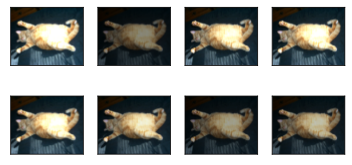

In [10]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

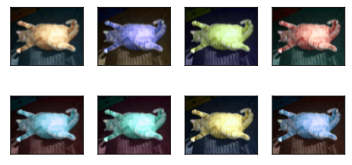

In [11]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

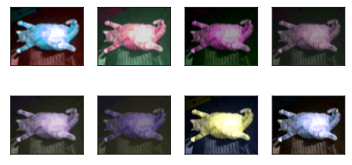

In [12]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

## Combining Multiple Image Augmentation Methods
In Pytorch using Compose technique

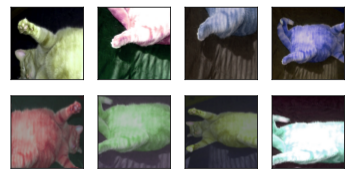

In [13]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), shape_au, color_aug
])
apply(img, augs)

# Training with Image Augmentation

100.0%


Extracting ../data\cifar-10-python.tar.gz to ../data


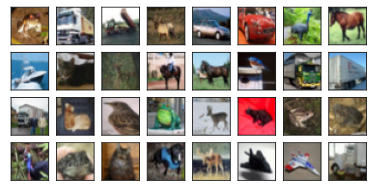

In [14]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In order to obtain definitive results during prediction, we usually only apply image augmentation to training examples, and do not use image augmentation with random operations during prediction. Here we only use the simplest random left-right flipping method. In addition, we use a ToTensor instance to convert a minibatch of images into the format required by the deep learning framework, i.e., 32-bit floating point numbers between 0 and 1 with the shape of (batch size, number of channels, height, width).

In [16]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs =  torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [17]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

##  Multi-GPU Training

In [23]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """
    Train for a minibatch with mutiple GPUs
    """
    if isinstance(X, list):
        # Required for BERT fine-tuning
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])

    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [25]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices = d2l.try_all_gpus()):
    """
    Train a model with multiple GPUs
    """
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids = devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
            test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
            animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')



In [26]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

A:\huan_shit\Dive_into_Deep_Learning\venv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


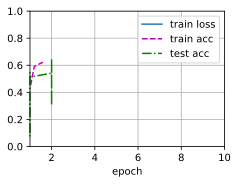

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

#  Summary
1. Image augmentation generates random images based on existing training data to improve the generalization ability of models.
2. In order to obtain definitive results during prediction, we usually only apply image augmentation to training examples, and do not use image augmentation with random operations during prediction.
3. Deep learning frameworks provide many different image augmentation methods, which can be applied simultaneously.